In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import random
import seaborn as sns
#import matplotlib as mpl
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
# Random seed for reproducibility
seed = 1

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
# Utility function to create folders and callbacks for training
from datetime import datetime

exp_dir = ''

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%Y-%m-%d_%H:%M')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tfk.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp'),
                                                save_weights_only=False,
                                                save_best_only=False)
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                               profile_batch=0,
                                               histogram_freq=1)
  callbacks.append(tb_callback)

In [4]:
#!unzip ANN_HW1.zip
#import zipfile
#with zipfile.ZipFile("dataset.zip", 'r') as z:
#    z.extractall()

In [5]:
# Set the path to the dataset 

dataset_dir = '../input/homework1split/'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

In [6]:
# Plot example images from dataset
'''
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
    if i < len(labels):
        class_imgs = next(os.walk('{}/{}/'.format(training_dir, labels[i])))[2]
        class_img = class_imgs[0]
        img = Image.open('{}/{}/{}'.format(training_dir, labels[i], class_img))
        ax = axes[i//num_col, i%num_col]
        ax.imshow(np.array(img))
        ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()
'''

"\nlabels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']\n\nnum_row = len(labels)//2\nnum_col = len(labels)//num_row\nfig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))\nfor i in range(len(labels)):\n    if i < len(labels):\n        class_imgs = next(os.walk('{}/{}/'.format(training_dir, labels[i])))[2]\n        class_img = class_imgs[0]\n        img = Image.open('{}/{}/{}'.format(training_dir, labels[i], class_img))\n        ax = axes[i//num_col, i%num_col]\n        ax.imshow(np.array(img))\n        ax.set_title('{}'.format(labels[i]))\nplt.tight_layout()\nplt.show()\n"

In [7]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_gen = ImageDataGenerator(rotation_range=30,
                              height_shift_range=50,
                              width_shift_range=50,
                              zoom_range=0.3,
                              horizontal_flip=True,
                              vertical_flip=True, 
                              fill_mode='reflect',
                              rescale=1/255)   
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method

train_dataset = train_gen.flow_from_directory(directory=training_dir,
                                                target_size=(256,256),
                                                color_mode='rgb',
                                                classes=None,
                                                batch_size=8,
                                                shuffle=True,
                                                class_mode='categorical',
                                                seed=seed)


valid_gen = ImageDataGenerator(rescale=1/255.)   

validation_dataset = valid_gen.flow_from_directory(directory=validation_dir,
                                                target_size=(256,256),
                                                color_mode='rgb',
                                                classes=None,
                                                batch_size=8,
                                                shuffle=True,
                                                class_mode='categorical',
                                                seed=seed)

Found 14176 images belonging to 14 classes.
Found 3552 images belonging to 14 classes.


In [8]:
input_shape = (256, 256, 3)
epochs = 150
learning_rate = 0.001
model_name = '8conv2dense'

In [9]:
def build_model(input_shape):
#create model

    model = tfk.Sequential()
    model.add(tfkl.Conv2D(8 ,kernel_size=(3, 3), padding='same', 
                          kernel_initializer=tfk.initializers.GlorotUniform(seed),
                          input_shape=input_shape, activation = 'relu'))
    model.add(tfkl.BatchNormalization(axis = 1))
    model.add(tfkl.Conv2D(8 ,kernel_size=(3, 3), padding='same', 
                          kernel_initializer=tfk.initializers.GlorotUniform(seed),
                          input_shape=input_shape, activation = 'relu'))
    model.add(tfkl.MaxPooling2D((2, 2),strides=(2,2)))
    

    model.add(tfkl.Conv2D(16,kernel_size=(3, 3), padding='same',
                          kernel_initializer=tfk.initializers.GlorotUniform(seed),
                          activation = 'relu'))
    model.add(tfkl.BatchNormalization(axis = 1))
    model.add(tfkl.Conv2D(16 ,kernel_size=(3, 3), padding='same', 
                          kernel_initializer=tfk.initializers.GlorotUniform(seed),
                          input_shape=input_shape, activation = 'relu'))
    model.add(tfkl.MaxPooling2D((2, 2),strides=(2,2)))
    
    
    model.add(tfkl.Conv2D(32,kernel_size=(3, 3), padding='same',
                          kernel_initializer=tfk.initializers.GlorotUniform(seed),
                          activation = 'relu')) 
    model.add(tfkl.BatchNormalization(axis = 1))
    model.add(tfkl.Conv2D(32 ,kernel_size=(3, 3), padding='same', 
                          kernel_initializer=tfk.initializers.GlorotUniform(seed),
                          input_shape=input_shape, activation = 'relu'))
    model.add(tfkl.MaxPooling2D((2, 2),strides=(2,2)))
    
    
    
    model.add(tfkl.Conv2D(64,kernel_size=(3, 3), padding='same',
                          kernel_initializer=tfk.initializers.GlorotUniform(seed),
                          activation = 'relu'))
    model.add(tfkl.BatchNormalization(axis = 1))
    model.add(tfkl.Conv2D(64 ,kernel_size=(3, 3), padding='same', 
                          kernel_initializer=tfk.initializers.GlorotUniform(seed),
                          input_shape=input_shape, activation = 'relu'))
    model.add(tfkl.MaxPooling2D((2, 2),strides=(2,2))) 

    
                          
    model.add(tfkl.Conv2D(128,kernel_size=(3, 3), padding='same',
                          kernel_initializer=tfk.initializers.GlorotUniform(seed),
                          activation = 'relu'))
    model.add(tfkl.BatchNormalization(axis = 1))
    model.add(tfkl.Conv2D(128 ,kernel_size=(3, 3), padding='same', 
                          kernel_initializer=tfk.initializers.GlorotUniform(seed),
                          input_shape=input_shape, activation = 'relu'))
    model.add(tfkl.MaxPooling2D((2, 2),strides=(2,2)))
    
    
    model.add(tfkl.Conv2D(256 ,kernel_size=(3, 3), padding='same', 
                          kernel_initializer=tfk.initializers.GlorotUniform(seed),
                          input_shape=input_shape, activation = 'relu'))
    model.add(tfkl.BatchNormalization(axis = 1))
    model.add(tfkl.Conv2D(256 ,kernel_size=(3, 3), padding='same', 
                          kernel_initializer=tfk.initializers.GlorotUniform(seed),
                          input_shape=input_shape, activation = 'relu'))
    model.add(tfkl.MaxPooling2D((2, 2),strides=(2,2)))
    
    
    model.add(tfkl.Conv2D(512 ,kernel_size=(3, 3), padding='same', 
                          kernel_initializer=tfk.initializers.GlorotUniform(seed),
                          input_shape=input_shape, activation = 'relu'))
    model.add(tfkl.BatchNormalization(axis = 1))
    model.add(tfkl.Conv2D(512 ,kernel_size=(3, 3), padding='same', 
                          kernel_initializer=tfk.initializers.GlorotUniform(seed),
                          input_shape=input_shape, activation = 'relu'))
    model.add(tfkl.MaxPooling2D((2, 2),strides=(2,2)))
    
                             
    model.add(tfkl.Flatten())
    model.add(tfkl.Dropout(0.5)) 
    
    
    model.add(tfkl.Dense(512, kernel_regularizer = tfk.regularizers.l2(0.001),
                         kernel_initializer=tfk.initializers.GlorotUniform(seed), 
                         activation = 'relu'))
    model.add(tfkl.Dropout(0.25))
  ###################################_MAYBE AFER THIS ONE WITH ANOTHER DENCE_#############################
    model.add(tfkl.Dense(14, activation='softmax'))
    
    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), 
                  optimizer=tfk.optimizers.Adam(0.0001), metrics='accuracy')

    # Return the model
    return model

2021-11-21 23:27:03.898349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-21 23:27:04.003989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-21 23:27:04.004779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-21 23:27:04.005920: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 8)       1024      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      2

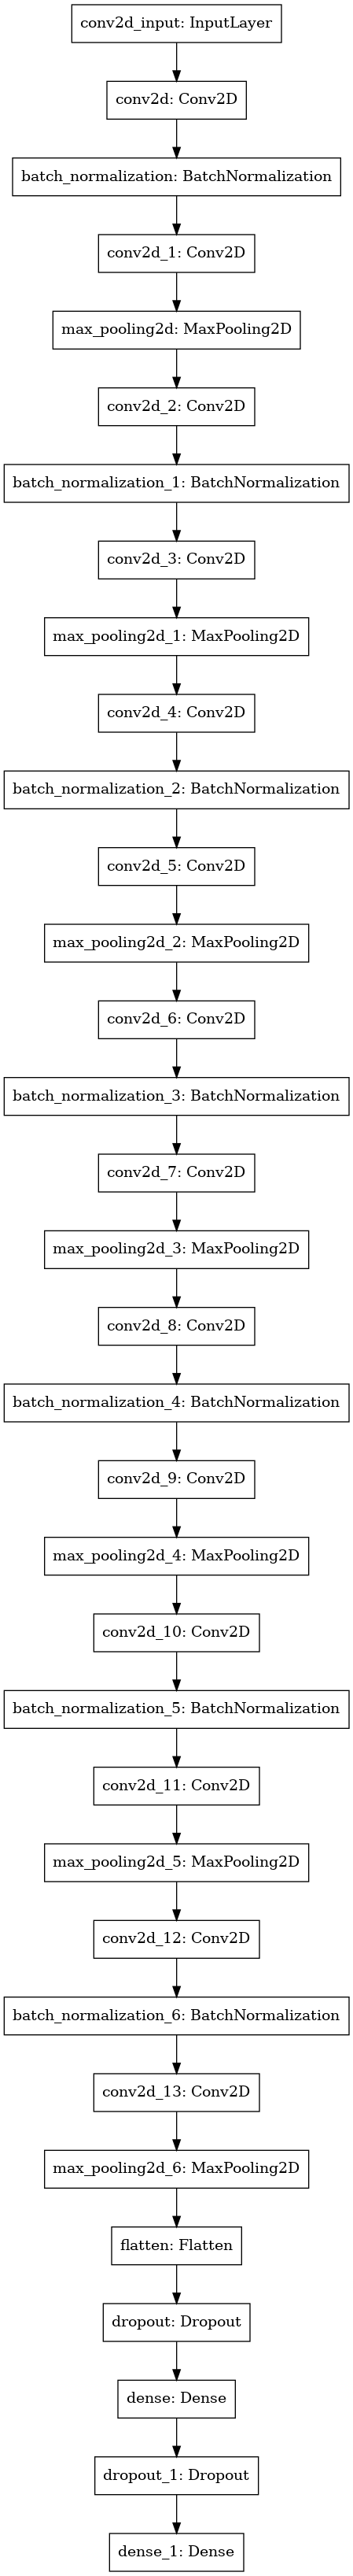

In [10]:
model = build_model(input_shape)
model.summary()
tfk.utils.plot_model(model)

In [11]:
callbacks = create_folders_and_callbacks(model_name=model_name)

# Train the model
history = model.fit(
    x = train_dataset,
    epochs = epochs,
    batch_size = 32,
    validation_data = validation_dataset,
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)]
).history

2021-11-21 23:27:07.861749: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2021-11-21 23:27:09.938688: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1772/1772 [==============================] - 306s 169ms/step - loss: 2.7116 - accuracy: 0.3880 - val_loss: 2.0349 - val_accuracy: 0.5197
Epoch 2/150
1772/1772 [==============================] - 225s 127ms/step - loss: 1.9624 - accuracy: 0.5366 - val_loss: 1.5743 - val_accuracy: 0.6056
Epoch 3/150
1772/1772 [==============================] - 232s 131ms/step - loss: 1.5133 - accuracy: 0.6270 - val_loss: 1.3351 - val_accuracy: 0.6430
Epoch 4/150
1772/1772 [==============================] - 236s 133ms/step - loss: 1.2181 - accuracy: 0.6849 - val_loss: 1.0289 - val_accuracy: 0.7252
Epoch 5/150
1772/1772 [==============================] - 238s 134ms/step - loss: 1.0051 - accuracy: 0.7344 - val_loss: 0.7965 - val_accuracy: 0.7829
Epoch 6/150
1772/1772 [==============================] - 238s 134ms/step - loss: 0.8712 - accuracy: 0.7639 - val_loss: 0.8995 - val_accuracy: 0.7624
Epoch 7/150
1772/1772 [==============================] - 238s 134ms/step - loss: 0.7639 - accuracy: 0.7956 - val_loss:

In [12]:
# Save the model
model.save(os.path.join(exp_dir, model_name))

2021-11-22 01:05:32.304442: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


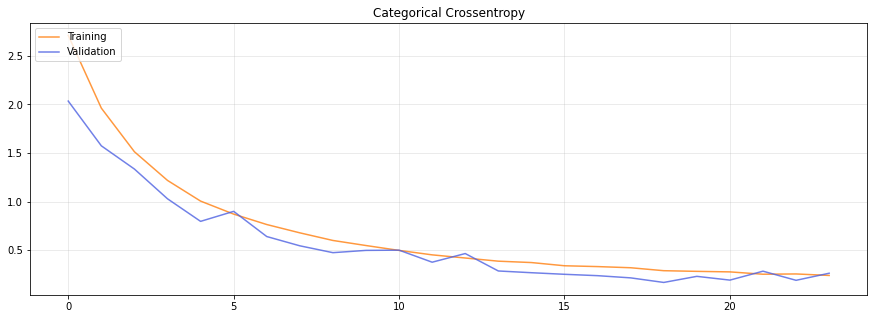

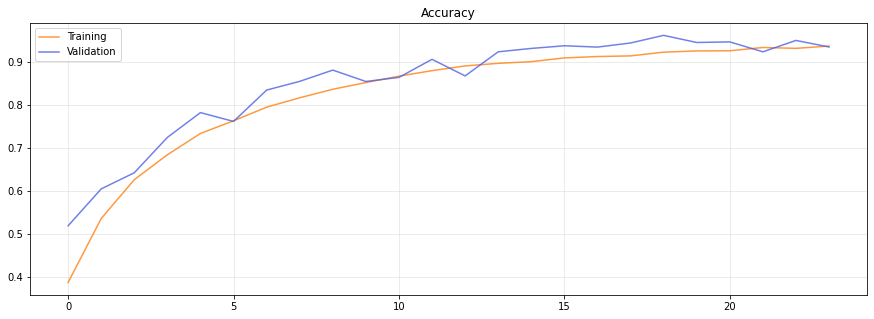

In [13]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()